In [1]:
import sqlite3
import os
import pandas as pd
from datetime import datetime, time, timedelta
from pytz import timezone, UTC
from airportsdata import load
import matplotlib.pyplot as plt
import pytz

# Global variables

mainbase = ['SGN', 'HAN', 'DAD', 'CXR', 'HPH','VII','PQC','VCA']
aircraft_types = ['A320', 'A321', 'A330']
airports = ['SGN', 'HAN', 'DAD', 'CXR']
file_path = '/Users/dongthan/Desktop/moc/acreadiness/csv/airports.csv'

## Bảng thông số tông số máy bay của hãng

vjc_fleet_total_ac = 86
a320_fleet_total= 18
a321_fleet_total  = 61
a330_fleet_total = 7
a320_wet_lease_total = 4
##
a321_ceo_fleet_total = 36
a321_neo_fleet_total = 11
a321_neo_acf_fleet_total = 14
##

total_ac_available = vjc_fleet_total_ac + a320_wet_lease_total

#  I. HÀM XỬ LÝ DỮ LIỆU

## 1. NORMALIZE TIME FORMAT => HH:MM

In [2]:
# Ép kiểu dữ liệu về định dạng HH:MM
def normalize_time_format(value):
    if pd.isnull(value):
        return None
    elif isinstance(value, (int, float)):
        # Chuyển đổi số thành chuỗi định dạng giờ
        return f"{int(value):02d}:00:00"
    elif isinstance(value, str):
        # Xử lý các định dạng chuỗi khác nhau
        try:
            datetime_obj = pd.to_datetime(value, format='%H:%M:%S.%f')
        except ValueError:
            try:
                datetime_obj = pd.to_datetime(value, format='%H:%M:%S')
            except ValueError:
                try:
                    datetime_obj = pd.to_datetime(value, format='%H:%M')
                except ValueError:
                    try:
                        datetime_obj = pd.to_datetime(value, format='%I:%M:%S %p')
                    except ValueError:
                        print(f"Could not convert time: {value}")
                        return None
        return datetime_obj.strftime('%H:%M:%S')
    elif isinstance(value, (datetime, time)):
        # Chuyển đổi datetime hoặc time thành chuỗi định dạng giờ
        return value.strftime('%H:%M:%S')
    elif isinstance(value, timedelta):
        # Chuyển đổi timedelta thành chuỗi định dạng giờ
        hours = value.total_seconds() // 3600
        minutes = (value.total_seconds() % 3600) // 60
        seconds = value.total_seconds() % 60
        return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"
    else:
        print(f"Unsupported data type: {type(value)}")
        return None
## Hàm chuyển đổi nhiều cột thời gian về định dạng chuẩn HH:MM

def normalize_time_columns(df, columns):
    for col in columns:
        df[col] = df[col].apply(normalize_time_format)
    return df

## Hàm chuyển đổi thời gian về đơn vị phút HH:MM -> MÍNUTES
def convert_to_minutes(value):
    if pd.isnull(value):
        return None
    elif isinstance(value, (int, float)):
        return int(value)
    elif isinstance(value, str):
        try:
            time_obj = pd.to_datetime(value, format='%H:%M:%S.%f').time()
        except ValueError:
            try:
                time_obj = pd.to_datetime(value, format='%H:%M:%S').time()
            except ValueError:
                try:
                    time_obj = pd.to_datetime(value, format='%H:%M').time()
                except ValueError:
                    print(f"Could not convert time: {value}")
                    return None
        return time_obj.hour * 60 + time_obj.minute
    elif isinstance(value, (datetime, time)):
        return value.hour * 60 + value.minute
    elif isinstance(value, timedelta):
        return value.total_seconds() // 60
    else:
        print(f"Unsupported data type: {type(value)}")
        return None
## Hàm chuyển đổi nhiều cột thời gian về đơn vị phút
def convert_many_cols_to_minutes(df, columns):
    for column in columns:
        df[column] = df[column].apply(convert_to_minutes)
    return df

def convert_to_time_string(value):
    if pd.isnull(value):
        return None
    elif isinstance(value, (int, float)):
        minutes = int(value)
        return f"{minutes // 60:02d}:{minutes % 60:02d}"
    elif isinstance(value, str):
        return value
    elif isinstance(value, (datetime, time)):
        return value.strftime('%H:%M')
    elif isinstance(value, timedelta):
        minutes = value.total_seconds() // 60
        return f"{int(minutes // 60):02d}:{int(minutes % 60):02d}"
    else:
        print(f"Unsupported data type: {type(value)}")
        return None

def convert_many_cols_to_time_string(df, columns):
    for col in columns:
        df[col] = df[col].apply(convert_to_time_string)
    return df

## Function - Expand df của D1,D2... D7 từ df dựa vào SEQ

In [3]:
def expand_freq_and_separate(df):
    # Create new columns for each day of the week
    for i in range(1, 8):
        df[f'FREQ-{i}'] = df['FREQ'].apply(lambda x: 1 if str(i) in str(x) else 0)

    # Create separate dataframes for each day using a list comprehension
    day_dfs = [df[df[f'FREQ-{i}'] == 1] for i in range(1, 8)]

    # Select columns and reset index for each dataframe
    cols = ['AC', 'ACTYPE', 'FLT_NO', 'DEP', 'ARR', 'ROUTE', 'STD', 'STA','FREQ', 'FROM', 'TO']
    day_dfs = [df[cols].reset_index(drop=True) for df in day_dfs]


    # Assign each dataframe to a separate variable
    df_D1, df_D2, df_D3, df_D4, df_D5, df_D6, df_D7 = day_dfs

    return df_D1, df_D2, df_D3, df_D4, df_D5, df_D6, df_D7



## Function - Calculate BLOCK TIME
- Sử dụng Py Timezone để tính block time

In [4]:
def calculate_block_time(row):
    dep_airport = row['DEP']
    arr_airport = row['ARR']
    std_time = row['STD']
    sta_time = row['STA']
    
    # Lấy thông tin sân bay từ thư viện airportsdata
    airports = load()
    
    # Kiểm tra và bổ sung thông tin về múi giờ của sân bay 'SGN' nếu không tồn tại
    if dep_airport and dep_airport not in airports:
        airports[dep_airport] = type('', (), {'timezone': 'Asia/Ho_Chi_Minh'})
    if arr_airport and arr_airport not in airports:
        airports[arr_airport] = type('', (), {'timezone': 'Asia/Ho_Chi_Minh'})
    
    # Lấy múi giờ của sân bay đi và sân bay đến
    dep_timezone = airports[dep_airport].timezone
    arr_timezone = airports[arr_airport].timezone
    
    # Chuyển đổi thời gian STD và STA thành đối tượng datetime với múi giờ tương ứng
    std_datetime = pd.to_datetime(std_time).time()
    sta_datetime = pd.to_datetime(sta_time).time()
    
    # Tạo đối tượng datetime với ngày mặc định và múi giờ tương ứng
    std_localized = timezone(dep_timezone).localize(datetime.combine(datetime.today(), std_datetime))
    sta_localized = timezone(arr_timezone).localize(datetime.combine(datetime.today(), sta_datetime))
    
    # Chuyển đổi thời gian STD và STA về giờ UTC
    std_utc = std_localized.astimezone(UTC)
    sta_utc = sta_localized.astimezone(UTC)
    
    # Kiểm tra nếu STA nhỏ hơn STD, cộng thêm 24 giờ vào STA
    if sta_utc < std_utc:
        sta_utc += timedelta(days=1)
    
    # Tính block time
    block_time = sta_utc - std_utc
    
    return block_time

def calculate_block_times(df):
    df['BLOCK_TIME'] = df.apply(calculate_block_time, axis=1)
    df = normalize_time_columns(df, ['BLOCK_TIME'])
    df = convert_many_cols_to_minutes(df, ['STA', 'STD', 'BLOCK_TIME'])
    return df

## Function - Calculate Ground time - TAT

In [5]:
def calculate_ground_time(df):
    grouped = df.groupby('AC')
    result = pd.DataFrame()

    for name, group in grouped:
        group = group.sort_values('STD')  # Ensure the group is sorted by STD
        group['GRD_TIME'] = group['STD'].shift(-1) - group['STA']
        group.loc[group['GRD_TIME'] < 0, 'GRD_TIME'] += 1440  # Add 1440 to negative ground times
        group['GRD_TIME'] = group['GRD_TIME'].fillna('-')  # Fill NaN values with '-'
        result = pd.concat([result, group])
        result = convert_many_cols_to_time_string(result, ['STA', 'STD', 'BLOCK_TIME','GRD_TIME'])
    return result

## Import & processing season flight plan 2024
 """
    Read an Excel file, drop rows and columns, rename columns, split values, convert data types,
    reorder columns, remove leading and trailing whitespaces, and remove duplicate rows based on a column.
    
    Returns:
    df (pandas.DataFrame): Processed DataFrame
    """


In [8]:
    
import pandas as pd

def process_data():
    """
    Read an Excel file, drop rows and columns, rename columns, split values, convert data types,
    reorder columns, remove leading and trailing whitespaces, and remove duplicate rows based on a column.
    
    Returns:
    df (pandas.DataFrame): Processed DataFrame
    """
    
    # Read the Excel file
    df = pd.read_excel('S24 270524_add new night flights more.xlsx', header=1)

    # Drop row NaN
    df = df.dropna(subset=['NO'])

    # Drop specified columns
    df = df.drop(columns=['NO','STD', 'STA', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16','BLOCK','TAT'])

    # Rename column
    df = df.rename(columns={'FLIGHT N0':'FLT_NO','STD.1':'STD','STA.1':'STA'})

    # Split ROUTE into DEP and ARR
    df[['DEP', 'ARR']] = df['ROUTE'].str.split('-', expand=True)

    # Create ACTYPE from AC
    df['ACTYPE'] = df['AC'].str.split('-').str[1]

    # Convert FREQ to string
    df['FREQ'] = df['FREQ'].astype(str)

    # Reorder columns
    cols = ["AC", "ACTYPE", "FLT_NO", "ROUTE", "DEP", "ARR", "STD", "STA", "FREQ", "FROM", "TO"]
    df = df[cols]

    # Remove leading and trailing whitespaces from all string values in the DataFrame
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    # Remove duplicate rows based on the 'FLT_NO' column
    df = df.drop_duplicates(subset='FLT_NO')
    
    return df

df = process_data()

KeyError: "['Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16'] not found in axis"

In [11]:
df = pd.read_excel('S24 270524_add new night flights more.xlsx', header=1)

In [12]:
df

,NO,AC,FLIGHT N0,ROUTE,STD,STA,BLOCK,TAT,FREQ,FROM,TO
0,1,1-A320,VJ206,SGN-TBB,06:05:00,07:15:00,01:10:00,00:25:00,246.0,2024-03-31,2024-10-26
1,1,1-A320,VJ207,TBB-SGN,07:40:00,08:50:00,01:10:00,00:30:00,246.0,2024-03-31,2024-10-26
2,1,1-A320,VJ396,SGN-PXU,06:15:00,07:25:00,01:10:00,00:25:00,1357.0,2024-03-31,2024-10-26
3,1,1-A320,VJ397,PXU-SGN,07:50:00,09:00:00,01:10:00,00:30:00,1357.0,2024-03-31,2024-10-26
4,1,1-A320,VJ1126,SGN-HAN,09:30:00,11:40:00,02:10:00,00:30:00,15.0,2024-03-31,2024-10-26
...,...,...,...,...,...,...,...,...,...,...,...
677,72,72-A330,VJ94,MEL-HAN,08:30:00,14:40:00,NaN,01:00:00,26.0,2024-10-06,2024-10-26
678,72,72-A330,VJ95,HAN-SYD,17:10:00,06:10:00,NaN,11:00:00,36.0,2024-06-08,2024-10-02
679,72,72-A330,VJ96,SYD-HAN,08:30:00,16:00:00,NaN,01:00:00,47.0,2024-06-09,2024-10-03
680,72,72-A330,VJ95,HAN-SYD,17:10:00,07:10:00,NaN,NaN,36.0,2024-10-05,2024-10-26


## Kiểm tra df

In [13]:
def check_df(df):
    """
    Display the first 10 and last 10 rows, information, summary statistics, shape, and columns of a DataFrame.
    
    Args:
    df (pandas.DataFrame): Input DataFrame
    """
    display(df.shape)
    display(df.columns)
    display(df.head(10))
    display(df.tail(10))
    display(df.info())
    display(df.describe())

check_df(df)

(682, 11)

Index(['NO', 'AC', 'FLIGHT N0', 'ROUTE', 'STD', 'STA', 'BLOCK', 'TAT', 'FREQ',
       'FROM', 'TO'],
      dtype='object')

,NO,AC,FLIGHT N0,ROUTE,STD,STA,BLOCK,TAT,FREQ,FROM,TO
0,1,1-A320,VJ206,SGN-TBB,06:05:00,07:15:00,01:10:00,00:25:00,246.0,2024-03-31,2024-10-26
1,1,1-A320,VJ207,TBB-SGN,07:40:00,08:50:00,01:10:00,00:30:00,246.0,2024-03-31,2024-10-26
2,1,1-A320,VJ396,SGN-PXU,06:15:00,07:25:00,01:10:00,00:25:00,1357.0,2024-03-31,2024-10-26
3,1,1-A320,VJ397,PXU-SGN,07:50:00,09:00:00,01:10:00,00:30:00,1357.0,2024-03-31,2024-10-26
4,1,1-A320,VJ1126,SGN-HAN,09:30:00,11:40:00,02:10:00,00:30:00,15.0,2024-03-31,2024-10-26
5,1,1-A320,VJ1523,HAN-DAD,12:10:00,13:30:00,01:20:00,00:25:00,15.0,2024-03-31,2024-10-26
6,1,1-A320,VJ1536,DAD-HAN,13:55:00,15:15:00,01:20:00,00:30:00,15.0,2024-03-31,2024-10-26
7,1,1-A320,VJ1151,HAN-SGN,15:45:00,17:55:00,02:10:00,00:30:00,15.0,2024-03-31,2024-10-26
8,1,1-A320,VJ128,SGN-HAN,09:30:00,11:40:00,02:10:00,00:30:00,23467.0,2024-03-31,2024-10-26
9,1,1-A320,VJ133,HAN-SGN,12:10:00,14:20:00,02:10:00,00:40:00,23467.0,2024-03-31,2024-10-26


,NO,AC,FLIGHT N0,ROUTE,STD,STA,BLOCK,TAT,FREQ,FROM,TO
672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
674,72,72-A330,VJ93,HAN-MEL,17:10:00,06:00:00,NaN,11:10:00,15.0,2024-06-03,2024-10-04
675,72,72-A330,VJ94,MEL-HAN,07:30:00,14:40:00,NaN,01:00:00,26.0,2024-06-04,2024-10-05
676,72,72-A330,VJ93,HAN-MEL,17:10:00,07:00:00,NaN,NaN,15.0,2024-10-07,2024-10-25
677,72,72-A330,VJ94,MEL-HAN,08:30:00,14:40:00,NaN,01:00:00,26.0,2024-10-06,2024-10-26
678,72,72-A330,VJ95,HAN-SYD,17:10:00,06:10:00,NaN,11:00:00,36.0,2024-06-08,2024-10-02
679,72,72-A330,VJ96,SYD-HAN,08:30:00,16:00:00,NaN,01:00:00,47.0,2024-06-09,2024-10-03
680,72,72-A330,VJ95,HAN-SYD,17:10:00,07:10:00,NaN,NaN,36.0,2024-10-05,2024-10-26
681,72,72-A330,VJ96,SYD-HAN,09:30:00,16:00:00,NaN,01:00:00,47.0,2024-10-06,2024-10-27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   NO         540 non-null    object        
 1   AC         540 non-null    object        
 2   FLIGHT N0  538 non-null    object        
 3   ROUTE      540 non-null    object        
 4   STD        540 non-null    object        
 5   STA        540 non-null    object        
 6   BLOCK      501 non-null    object        
 7   TAT        524 non-null    object        
 8   FREQ       540 non-null    float64       
 9   FROM       540 non-null    datetime64[ns]
 10  TO         540 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(8)
memory usage: 58.7+ KB


None

,FREQ
count,5.400000e+02
mean,8.764688e+05
std,5.598372e+05
min,1.000000e+00
25%,1.013375e+04
50%,1.234567e+06
75%,1.234567e+06
max,1.234567e+06


### Vẽ biểu đồ kiểm tra thông tin dữ liệu của df

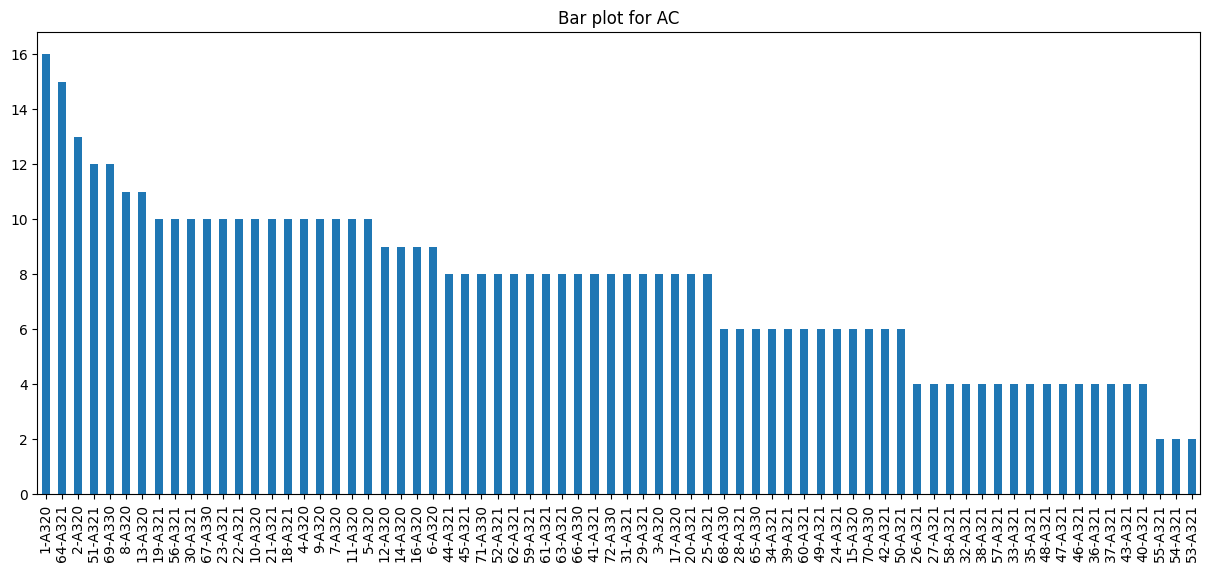

AttributeError: 'float' object has no attribute 'hour'

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bar(df, column, title):
    plt.figure(figsize=(15, 6))
    df[column].value_counts().plot(kind='bar')
    plt.title(title)
    plt.show()

def calculate_minutes(df, sta_column, std_column):
    df['STA_minutes'] = df[sta_column].apply(lambda t: t.hour*60 + t.minute)
    df['STD_minutes'] = df[std_column].apply(lambda t: t.hour*60 + t.minute)
    return df

def plot_correlation_heatmap(df, columns):
    corr = df[columns].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation matrix heatmap')
    plt.show()

# Example usage
plot_bar(df, 'AC', 'Bar plot for AC')


df = calculate_minutes(df, 'STA', 'STD')
plot_correlation_heatmap(df, ['STA_minutes', 'STD_minutes'])

## Expand df to df_D1, df_D2...
- Dựa vào FREQ để tách df theo ngày

In [128]:
df_D1, df_D2, df_D3, df_D4, df_D5, df_D6, df_D7 = expand_freq_and_separate(df)



In [131]:
display(df_D1.head(10))


,AC,ACTYPE,FLT_NO,DEP,ARR,ROUTE,STD,STA,FREQ,FROM,TO
0,1-A320,A320,VJ396,SGN,PXU,SGN-PXU,06:15:00,07:25:00,1357.0,2024-03-31,2024-10-26
1,1-A320,A320,VJ397,PXU,SGN,PXU-SGN,07:50:00,09:00:00,1357.0,2024-03-31,2024-10-26
2,1-A320,A320,VJ1126,SGN,HAN,SGN-HAN,09:30:00,11:40:00,15.0,2024-03-31,2024-10-26
3,1-A320,A320,VJ1523,HAN,DAD,HAN-DAD,12:10:00,13:30:00,15.0,2024-03-31,2024-10-26
4,1-A320,A320,VJ1536,DAD,HAN,DAD-HAN,13:55:00,15:15:00,15.0,2024-03-31,2024-10-26
5,1-A320,A320,VJ1151,HAN,SGN,HAN-SGN,15:45:00,17:55:00,15.0,2024-03-31,2024-10-26
6,1-A320,A320,VJ312,SGN,HUI,SGN-HUI,20:20:00,21:45:00,1234567.0,2024-03-31,2024-10-26
7,1-A320,A320,VJ313,HUI,SGN,HUI-SGN,22:10:00,23:35:00,1234567.0,2024-03-31,2024-10-26
8,2-A320,A320,VJ198,SGN,HAN,SGN-HAN,05:25:00,07:35:00,12456.0,2024-03-31,2024-10-26
9,2-A320,A320,VJ125,HAN,SGN,HAN-SGN,08:05:00,10:15:00,12456.0,2024-03-31,2024-10-26


### Vẽ biểu đồ D1 D2

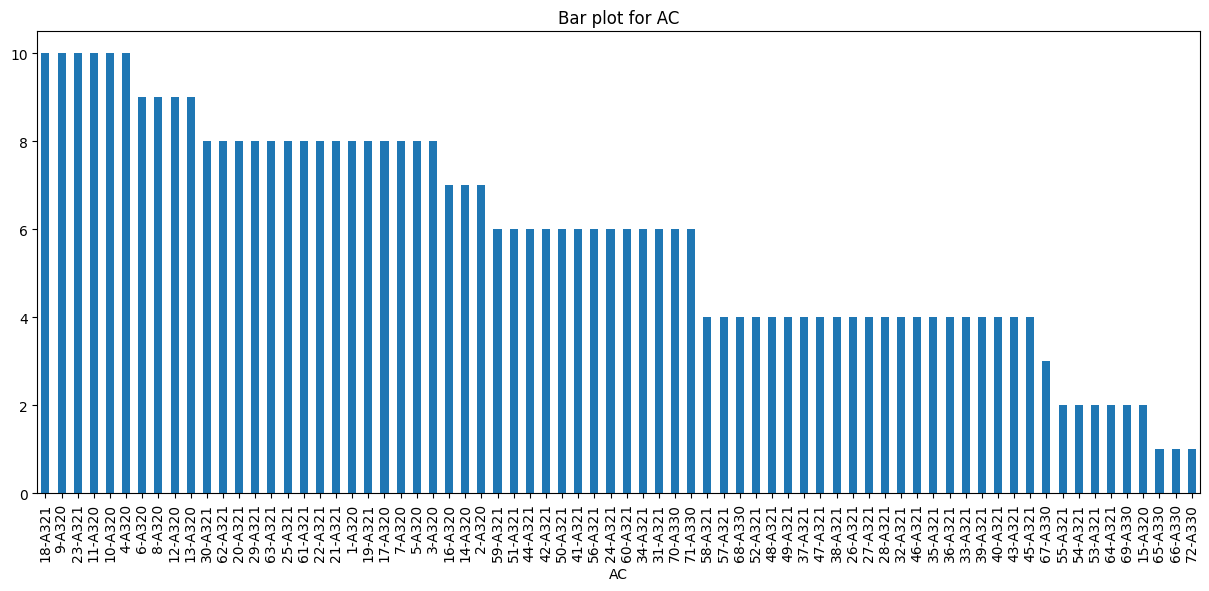

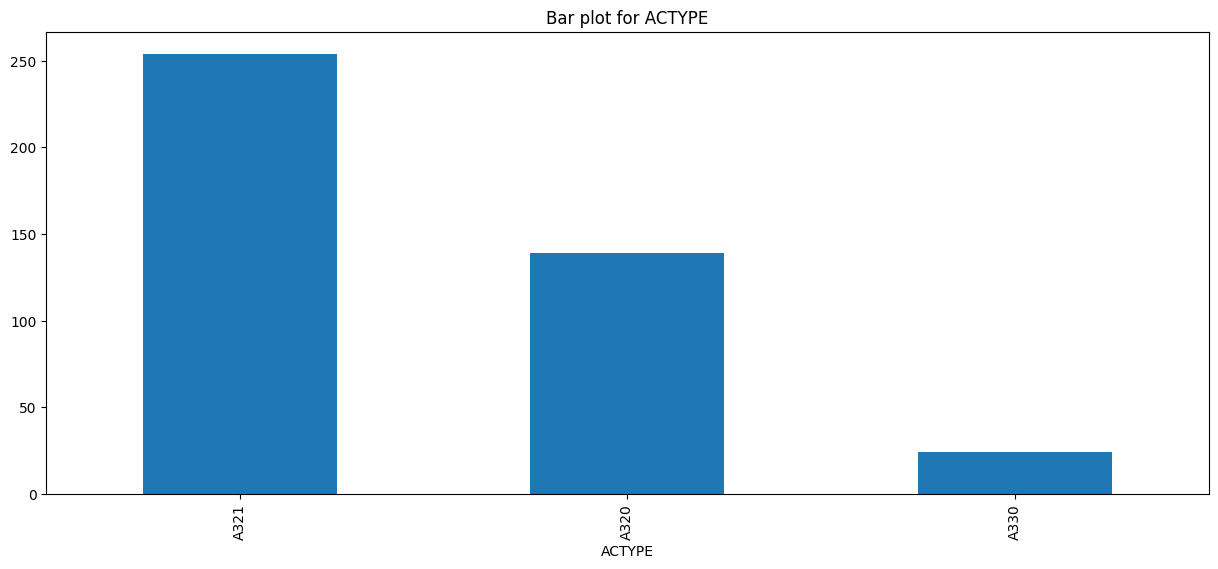

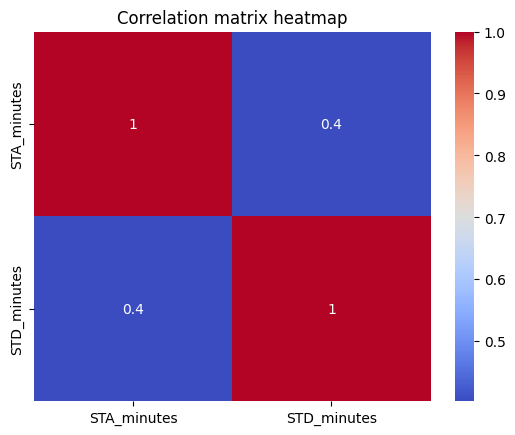

In [46]:
# D1 - Monday : Overview of the data
plot_bar(df_D1, 'AC', 'Bar plot for AC')
plot_bar(df_D1, 'ACTYPE', 'Bar plot for ACTYPE')

df_D1_plot = calculate_minutes(df_D1, 'STA', 'STD')
plot_correlation_heatmap(df_D1_plot, ['STA_minutes', 'STD_minutes'])

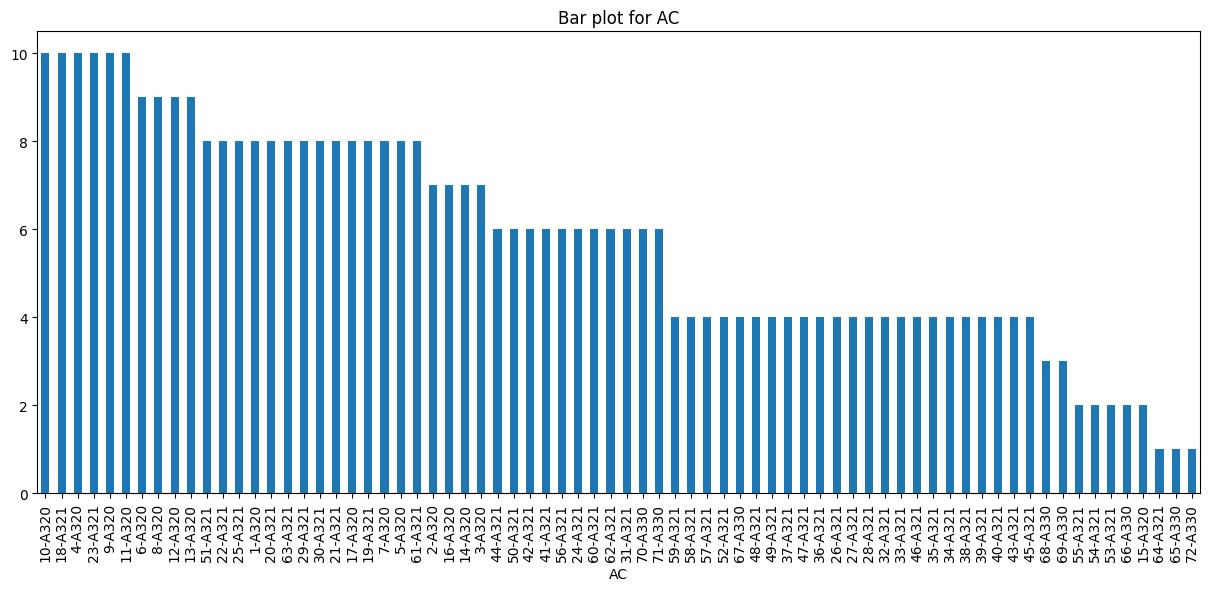

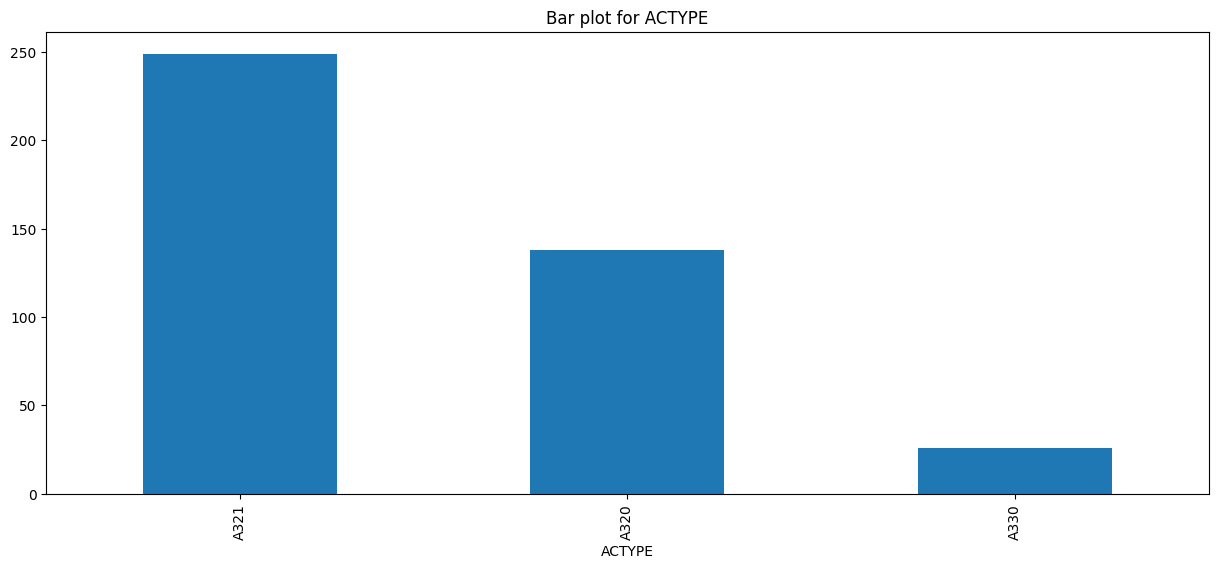

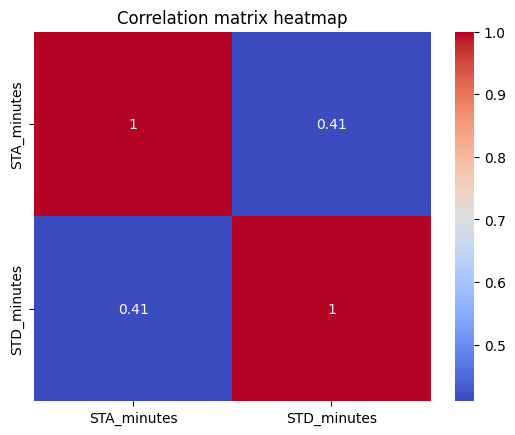

In [47]:
# D2 - Tue : Overview of the data
plot_bar(df_D2, 'AC', 'Bar plot for AC')
plot_bar(df_D2, 'ACTYPE', 'Bar plot for ACTYPE')

df_D2_plot = calculate_minutes(df_D2, 'STA', 'STD')
plot_correlation_heatmap(df_D2_plot, ['STA_minutes', 'STD_minutes'])

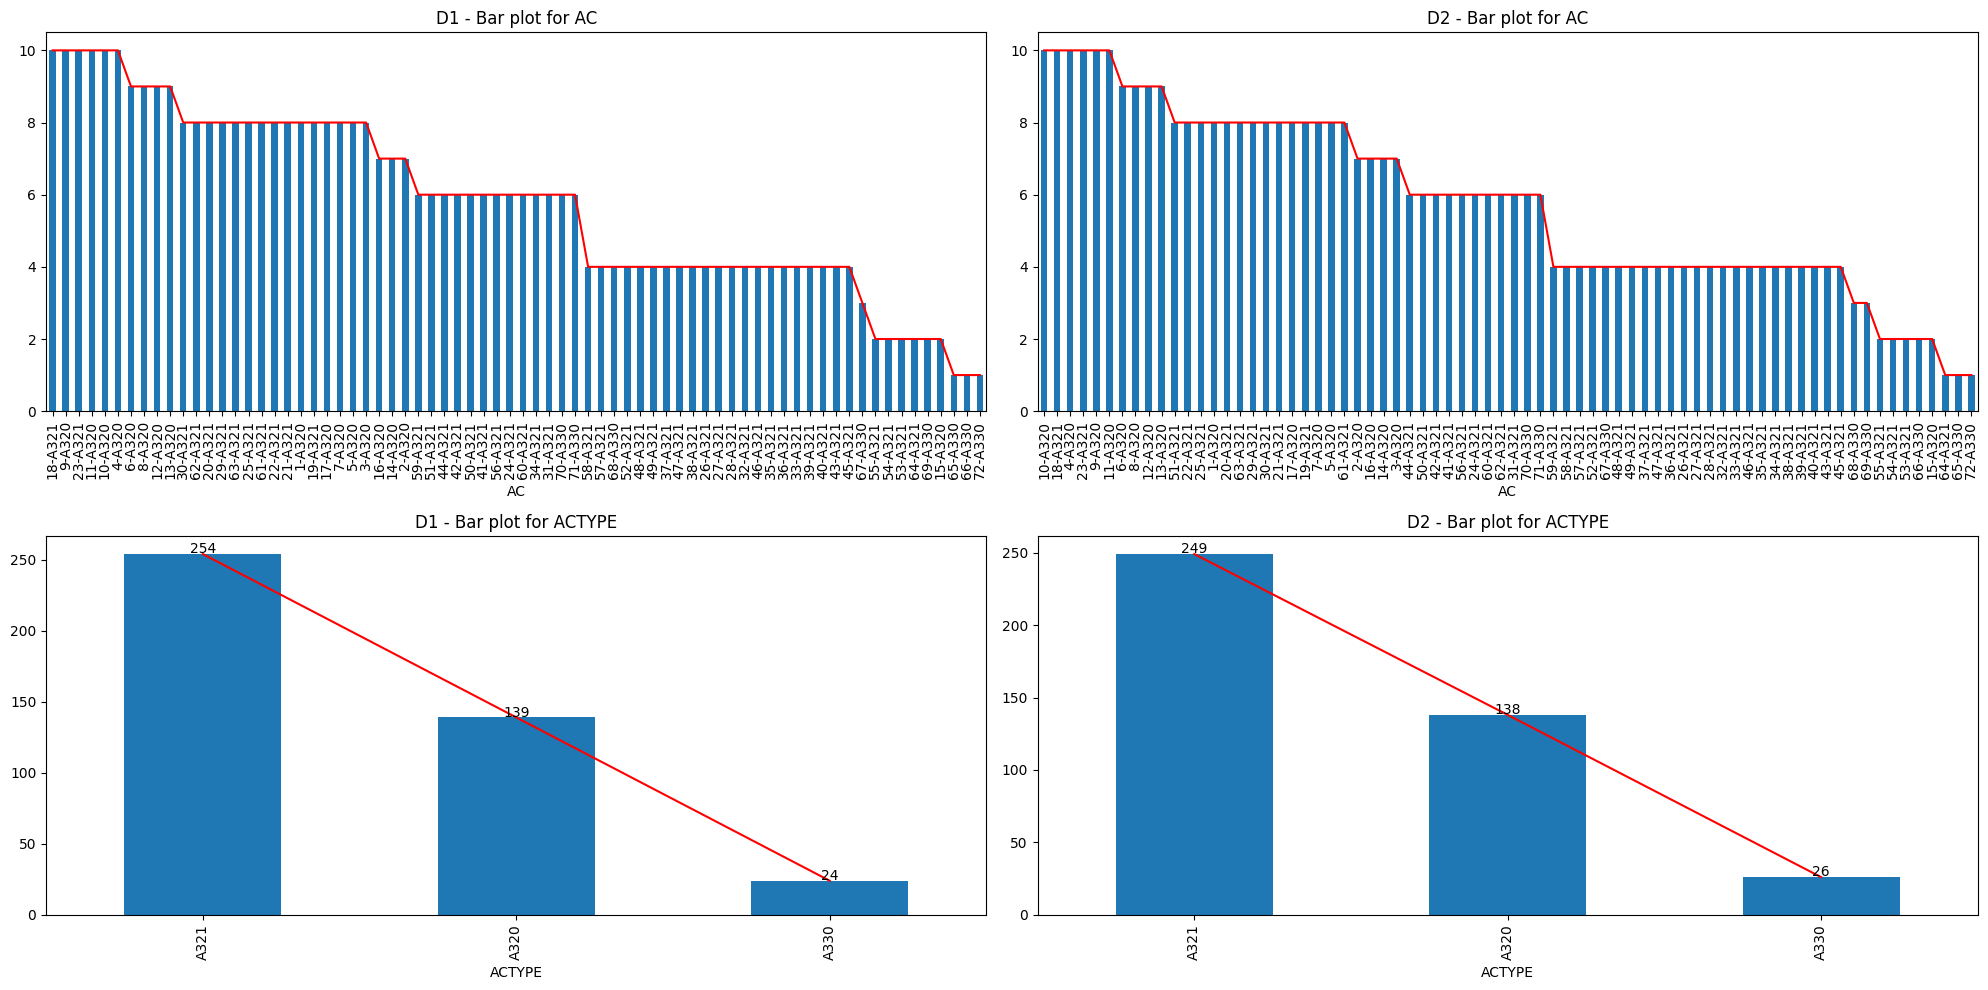

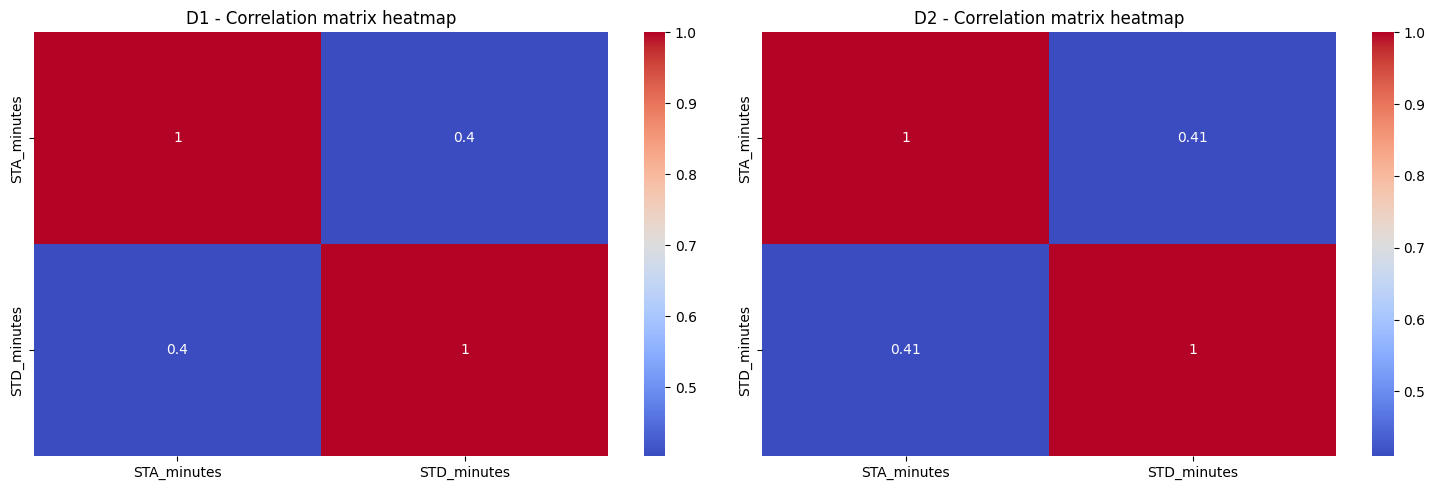

In [55]:
import numpy as np

# Create a figure with 2 subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Bar plots for AC
df_D1_AC_counts = df_D1['AC'].value_counts()
df_D1_AC_counts.plot(kind='bar', ax=axs[0, 0], title='D1 - Bar plot for AC')
axs[0, 0].plot(np.arange(len(df_D1_AC_counts)), df_D1_AC_counts.values, color='r')  # Add trend line

df_D2_AC_counts = df_D2['AC'].value_counts()
df_D2_AC_counts.plot(kind='bar', ax=axs[0, 1], title='D2 - Bar plot for AC')
axs[0, 1].plot(np.arange(len(df_D2_AC_counts)), df_D2_AC_counts.values, color='r')  # Add trend line

# Bar plots for ACTYPE
df_D1_ACTYPE_counts = df_D1['ACTYPE'].value_counts()
df_D1_ACTYPE_counts.plot(kind='bar', ax=axs[1, 0], title='D1 - Bar plot for ACTYPE')
axs[1, 0].plot(np.arange(len(df_D1_ACTYPE_counts)), df_D1_ACTYPE_counts.values, color='r')  # Add trend line
for i, v in enumerate(df_D1_ACTYPE_counts.values):  # Add counts above bars
    axs[1, 0].text(i, v + 0.5, str(v), ha='center')

df_D2_ACTYPE_counts = df_D2['ACTYPE'].value_counts()
df_D2_ACTYPE_counts.plot(kind='bar', ax=axs[1, 1], title='D2 - Bar plot for ACTYPE')
axs[1, 1].plot(np.arange(len(df_D2_ACTYPE_counts)), df_D2_ACTYPE_counts.values, color='r')  # Add trend line
for i, v in enumerate(df_D2_ACTYPE_counts.values):  # Add counts above bars
    axs[1, 1].text(i, v + 0.5, str(v), ha='center')

plt.tight_layout()
plt.show()

# Calculate minutes for STA and STD
df_D1_plot = calculate_minutes(df_D1, 'STA', 'STD')
df_D2_plot = calculate_minutes(df_D2, 'STA', 'STD')

# Correlation heatmaps
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(df_D1_plot[['STA_minutes', 'STD_minutes']].corr(), annot=True, cmap='coolwarm', ax=axs[0])
axs[0].set_title('D1 - Correlation matrix heatmap')

sns.heatmap(df_D2_plot[['STA_minutes', 'STD_minutes']].corr(), annot=True, cmap='coolwarm', ax=axs[1])
axs[1].set_title('D2 - Correlation matrix heatmap')

plt.tight_layout()
plt.show()

In [77]:
total_A321_used_df_D1 = df_D1[df_D1['ACTYPE'] == 'A321']['AC'].nunique()
total_A320_used_df_D1 = df_D1[df_D1['ACTYPE'] == 'A320']['AC'].nunique()
total_A330_used_df_D1 = df_D1[df_D1['ACTYPE'] == 'A330']['AC'].nunique()

print(f"Tổng số máy bay A321 sử dụng trong ngày D1: {total_A321_used_df_D1} ,Số máy dư = {a321_fleet_total - total_A321_used_df_D1}")
print(f"Tổng số máy bay A320 sử dụng trong ngày D1: {total_A320_used_df_D1}, Số máy dư = {a320_fleet_total - total_A320_used_df_D1}")
print(f"Tổng số máy bay A330 sử dụng trong ngày D1: {total_A330_used_df_D1}, Số máy dư = {a330_fleet_total - total_A330_used_df_D1}")
print("Tổng số may bay sử dụng trong ngày D1: ", total_A321_used_df_D1 + total_A320_used_df_D1 + total_A330_used_df_D1)

Tổng số máy bay A321 sử dụng trong ngày D1: 47 ,Số máy dư = 14
Tổng số máy bay A320 sử dụng trong ngày D1: 17, Số máy dư = 1
Tổng số máy bay A330 sử dụng trong ngày D1: 8, Số máy dư = -1
Tổng số may bay sử dụng trong ngày D1:  72


In [79]:
df_D1_ACTYPE_counts = df_D1['ACTYPE'].value_counts()
df_D1_ACTYPE_counts

ACTYPE
A321    254
A320    139
A330     24
Name: count, dtype: int64

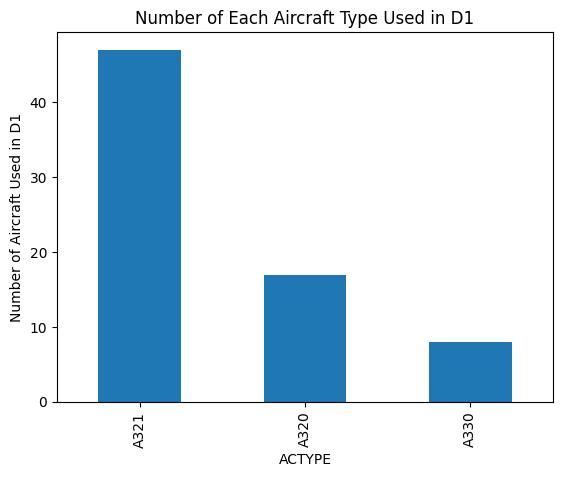

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Tạo DataFrame mới
data = {
    'ACTYPE': ['A321', 'A320', 'A330'],
    'Used_in_D1': [total_A321_used_df_D1, total_A320_used_df_D1, total_A330_used_df_D1]
}
df_new = pd.DataFrame(data)

# Vẽ biểu đồ bar
df_new.plot(x='ACTYPE', y='Used_in_D1', kind='bar', legend=False)
plt.ylabel('Number of Aircraft Used in D1')
plt.title('Number of Each Aircraft Type Used in D1')
plt.show()

## ADD COL BLOCK TIME AND TAT (GRD_TIME)

In [122]:
df_D1 = convert_many_cols_to_minutes(df_D1, ['STA', 'STD'])


In [126]:
df_D1 = calculate_block_times(df_D1)

In [24]:
# Sắp xêp lại dữ liệu FLT NO của df
flight_no_df = df.copy()

In [25]:
flight_no_df

,AC,ACTYPE,FLT_NO,ROUTE,DEP,ARR,STD,STA,FREQ,FROM,TO,FLT_NUM,NEXT_FLT_NUM,NEXT_ARR,NEXT_DEP
617,69-A330,A330,VJ61,CXR-ALA,CXR,ALA,18:00:00,23:35:00,135.0,2024-03-31,2024-10-25,61,62.0,CXR,ALA
618,69-A330,A330,VJ62,ALA-CXR,ALA,CXR,01:05:00,10:20:00,246.0,2024-03-31,2024-10-26,62,67.0,NQZ,CXR
619,69-A330,A330,VJ67,CXR-NQZ,CXR,NQZ,12:40:00,18:55:00,47.0,2024-03-31,2024-10-24,67,68.0,CXR,NQZ
620,69-A330,A330,VJ68,NQZ-CXR,NQZ,CXR,20:25:00,06:15:00,47.0,2024-03-31,2024-10-24,68,80.0,PER,ADL
564,64-A321,A321,VJ80,ADL-PER,ADL,PER,1900-01-24 08:30:00,1900-01-24 10:30:00,26.0,2024-04-01,2024-04-06,80,81.0,MEL,SGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,63-A321,A321,VJ3901,PVG-SGN,PVG,SGN,01:55:00,05:40:00,1234567.0,2024-03-31,2024-10-26,3901,3930.0,TFU,SGN
270,25-A321,A321,VJ3930,SGN-TFU,SGN,TFU,22:20:00,02:00:00,1234567.0,2024-03-31,2024-10-26,3930,3931.0,SGN,TFU
271,25-A321,A321,VJ3931,TFU-SGN,TFU,SGN,03:00:00,04:50:00,1234567.0,2024-04-01,2024-10-26,3931,3932.0,XIY,SGN
35,3-A320,A320,VJ3932,SGN-XIY,SGN,XIY,20:05:00,01:30:00,1357.0,2024-03-31,2024-10-26,3932,3933.0,SGN,XIY


In [26]:
flt_no_cols = ['FLT_NO', 'ROUTE', 'DEP', 'ARR', 'STD', 'STA', 'FREQ']

In [27]:
flight_no_df = flight_no_df[flt_no_cols]

In [18]:
# Sắp xếp cột FLT_NO
flight_no_df = flight_no_df.sort_values('FLT_NO')
flight_no_df.to_excel('flight_no.xlsx', index=False)

In [32]:
# Create a copy of the DataFrame to avoid SettingWithCopyWarning
flight_no_df_copy = flight_no_df.copy()

# Tạo cột mới 'FLT_NUM' chứa số trong FLT_NO
flight_no_df_copy.loc[:, 'FLT_NUM'] = flight_no_df_copy['FLT_NO'].str[2:].astype(int)

# Lấy các chuyến bay có DEP là mainbase
mainbase_flights = flight_no_df_copy[flight_no_df_copy['DEP'] == 'mainbase']

# Tìm các cặp chuyến bay
pair_indices = mainbase_flights['FLT_NUM'].apply(lambda x: flight_no_df_copy['FLT_NUM'].eq(x+1).any())
pairs = mainbase_flights[pair_indices]

# Tìm các chuyến bay không phải là một cặp
non_pairs = flight_no_df_copy[~flight_no_df_copy.index.isin(pairs.index)]

# In kết quả
print("Pairs: ")
display(pairs)
print("Non-pairs: ")
display(non_pairs)

Pairs: 


""


Non-pairs: 


,FLT_NO,ROUTE,DEP,ARR,STD,STA,FREQ,FLT_NUM
617,VJ61,CXR-ALA,CXR,ALA,18:00:00,23:35:00,135.0,61
618,VJ62,ALA-CXR,ALA,CXR,01:05:00,10:20:00,246.0,62
619,VJ67,CXR-NQZ,CXR,NQZ,12:40:00,18:55:00,47.0,67
620,VJ68,NQZ-CXR,NQZ,CXR,20:25:00,06:15:00,47.0,68
564,VJ80,ADL-PER,ADL,PER,1900-01-24 08:30:00,1900-01-24 10:30:00,26.0,80
...,...,...,...,...,...,...,...,...
559,VJ3901,PVG-SGN,PVG,SGN,01:55:00,05:40:00,1234567.0,3901
270,VJ3930,SGN-TFU,SGN,TFU,22:20:00,02:00:00,1234567.0,3930
271,VJ3931,TFU-SGN,TFU,SGN,03:00:00,04:50:00,1234567.0,3931
35,VJ3932,SGN-XIY,SGN,XIY,20:05:00,01:30:00,1357.0,3932
